In [17]:
%config InlineBackend.figure_format = "svg"

import time
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

# Import data and create datasets

As labels dos dados estão definidas tais que:
- Background: 0
- Sinal: 1

In [2]:
# Gather data
bkgd = pd.read_hdf("Data/Background.h5", key='bkgd')
fcnc = pd.read_hdf("Data/FCNC.h5", key="fcnc")
data = pd.concat([bkgd, fcnc])
data

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.482720,158.952774,595.341003,...,0.443487,407.632080,-0.755916,0.785445,292.118774,2.734722,2,1212.756226,1.304437e-07,0
1,-2.060421,30.932735,-1.365277,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-2.106180,54.675926,2.572098,0.000000,0.000000,0.000000,1,352.939209,1.304437e-07,0
2,-1.025947,40.282574,-1.773086,0.288352,26.201660,-0.694144,2,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,419.889740,1.304437e-07,0
3,1.084838,82.556099,2.932473,0.000000,0.000000,0.000000,1,0.969367,103.233589,318.344971,...,-0.059388,43.076065,-2.346566,0.000000,0.000000,0.000000,1,610.762146,1.304437e-07,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,1.464516,80.244713,-2.605392,1.797688,23.799982,2.562366,2,291.874695,1.304437e-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,2.364251,79.450447,-2.115078,1.581713,46.098675,0.268987,2,306.712402,3.264224e-09,1
496618,-0.847799,214.928589,-2.360383,0.059395,31.239508,-2.978243,2,-0.959045,70.461861,257.986145,...,-1.299547,46.357815,-2.891009,0.000000,0.000000,0.000000,1,541.768921,3.264224e-09,1
496623,-0.230892,80.927383,-0.913889,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-0.219239,120.608452,1.697549,0.000000,0.000000,0.000000,1,305.327148,3.264224e-09,1
496624,0.584297,143.974167,2.141792,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-0.948717,27.718317,-0.361032,0.000000,0.000000,0.000000,1,404.741730,3.264224e-09,1


In [5]:
# Split data into training and testing
index_train, index_tests = train_test_split(data.index, test_size=2/3, random_state=42)
index_val, index_test = train_test_split(index_tests, test_size=0.5, random_state=40)

In [6]:
print(f"Train_size: {len(index_train)} | Val_size: {len(index_val)} | Test_size: {len(index_test)}")

Train_size: 1480266 | Val_size: 1480267 | Test_size: 1480267


In [7]:
# Get sample weights
train_weights = data.loc[index_train]["gen_weights"].values
val_weights = data.loc[index_val]["gen_weights"].values
test_weights = data.loc[index_test]["gen_weights"].values

# Get training features and labels
y_train = data.loc[index_train]["Label"].values
X_train = data.loc[index_train].drop(["Label", "gen_weights"], axis=1).values

# Get validation training features and labels
y_val = data.loc[index_val]["Label"].values
X_val = data.loc[index_val].drop(["Label", "gen_weights"], axis=1).values

# Get testing features and labels
y_test = data.loc[index_test]["Label"].values
X_test = data.loc[index_test].drop(["Label", "gen_weights"], axis=1).values

# Get class weights
# Class 0 (background) is the reference class, with weight 1
class_weights = {
    0: 1,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}

In [9]:
print(f"Class weights:\n{class_weights}\n")
print(f"Train_weights:\n{train_weights}\n")
print(f"Val_weights:\n{val_weights}\n")
print(f"Test_weights:\n{test_weights}\n")
print(f"X_train:\n{X_train}\n")
print(f"y_train:\n{y_train}\n")
print(f"X_val:\n{X_val}\n")
print(f"y_val:\n{y_val}\n")
print(f"X_test:\n{X_test}\n")
print(f"y_test:\n{y_test}\n")

Class weights:
{0: 1, 1: 15.228397627616971}

Train_weights:
[5.84247368e-07 2.37461767e-05 2.45847956e-05 ... 3.26422429e-09
 2.45847956e-05 2.37461767e-05]

Val_weights:
[2.45847956e-05 3.65150953e-03 5.84247368e-07 ... 3.39744848e-06
 4.28586718e-07 2.37461767e-05]

Test_weights:
[1.71797290e-04 1.57141084e-04 3.26422429e-09 ... 2.37461767e-05
 2.37461767e-05 5.84247368e-07]

X_train:
[[-2.37723136e+00  2.22883968e+01  1.50469542e+00 ...  0.00000000e+00
   1.00000000e+00  4.74350586e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.99464452e-01
   2.00000000e+00  2.08572754e+02]
 [-1.04501700e+00  9.97061157e+01  5.84959872e-02 ...  0.00000000e+00
   1.00000000e+00  4.26062378e+02]
 ...
 [ 1.46371841e+00  3.39957458e+02  4.40391511e-01 ...  0.00000000e+00
   0.00000000e+00  1.05735388e+03]
 [ 5.15887201e-01  2.04379234e+01  2.43531656e+00 ...  0.00000000e+00
   1.00000000e+00  2.42583435e+02]
 [ 8.32586765e-01  1.74524094e+02 -2.63093662e+00 ...  0.00000000e+00
   0.0000

In [10]:
print(f"X_train: {X_train.shape} | y_train: {y_train.shape} | train_weights: {train_weights.shape}")
print(f"X_val: {X_val.shape} | y_val: {y_val.shape} | val_weights: {val_weights.shape}")
print(f"X_test: {X_test.shape} | y_test: {y_test.shape} | test_weights: {test_weights.shape}")

X_train: (3201376, 69) | y_train: (3201376,) | train_weights: (3201376,)
X_val: (3201532, 69) | y_val: (3201532,) | val_weights: (3201532,)
X_test: (3199536, 69) | y_test: (3199536,) | test_weights: (3199536,)


# Build the model

In [11]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_samples):
        self.means = np.mean(data_samples, axis=0, keepdims=True)
        self.stds = np.std(data_samples, axis=0, keepdims=True)
        
    def call(self, inputs):
        return (inputs - self.means) / (self.stds + keras.backend.epsilon())
    
std_layer = Standardization()
std_layer.adapt(X_train)

In [12]:
inputs = keras.Input(shape=(69,))
standardize = std_layer(inputs)
fc1 = keras.layers.Dense(90, activation='relu')(inputs)
fc2 = keras.layers.Dense(120, activation='relu')(fc1)
fc3 = keras.layers.Dense(80, activation='relu')(fc2)
fc4 = keras.layers.Dense(40, activation='relu')(fc3)
outputs = keras.layers.Dense(1, activation='sigmoid')(fc4)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
dense (Dense)                (None, 90)                6300      
_________________________________________________________________
dense_1 (Dense)              (None, 120)               10920     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                9680      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 30,181
Trainable params: 30,181
Non-trainable params: 0
_________________________________________________________

In [13]:
# Model name
name = str(time.time())

# Callbacks 

In [14]:
# Tensorboard
TB = keras.callbacks.TensorBoard("logs/" + name)

# Early Stopping
ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=2, mode="min")

# Model Checkpoint
MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, monitor="val_loss",
                                     mode="min")

# Treinar modelo

AUC de aproximadamente 0.6 -> muito baixa!

In [15]:
history = model.fit(X_train, y_train, batch_size=1024,
                    epochs=10, validation_data=(X_val, y_val),
                    sample_weight=train_weights, class_weight=class_weights,
                    shuffle=True, callbacks=[TB, ES, MC])

Epoch 1/10
3127/3127 [==============================] - 53s 17ms/step - loss: 7.8670e-08 - accuracy: 0.9385 - auc: 0.5239 - val_loss: 0.8160 - val_accuracy: 0.9387 - val_auc: 0.5597
Epoch 2/10
3127/3127 [==============================] - 54s 17ms/step - loss: 4.5744e-08 - accuracy: 0.9387 - auc: 0.5544 - val_loss: 0.7194 - val_accuracy: 0.9389 - val_auc: 0.5643
Epoch 3/10
3127/3127 [==============================] - 55s 18ms/step - loss: 4.5935e-08 - accuracy: 0.9387 - auc: 0.5557 - val_loss: 0.7359 - val_accuracy: 0.9386 - val_auc: 0.5559
Epoch 4/10
3127/3127 [==============================] - 55s 18ms/step - loss: 4.1097e-08 - accuracy: 0.9387 - auc: 0.5671 - val_loss: 0.6697 - val_accuracy: 0.9390 - val_auc: 0.5769
Epoch 5/10
3127/3127 [==============================] - 54s 17ms/step - loss: 3.8483e-08 - accuracy: 0.9389 - auc: 0.5809 - val_loss: 1.0304 - val_accuracy: 0.9385 - val_auc: 0.5005
Epoch 6/10
3127/3127 [==============================] - 55s 17ms/step - loss: 3.9277e-08 -

# Tests and predictions

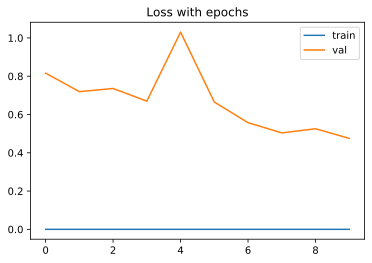

In [18]:
plt.title("Loss with epochs")
plt.plot(history.history["loss"], label='train')
plt.plot(history.history["val_loss"], label='val')
plt.legend()
plt.show()

In [22]:
y_preds = model.predict(X_test, batch_size=1024).reshape(-1)

In [23]:
accuracy_score(y_test, y_preds.round())

0.9398100224532557

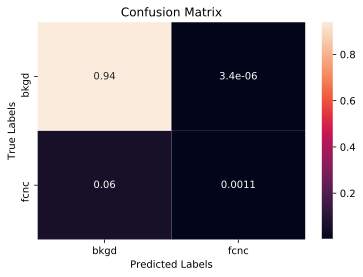

In [31]:
cm = confusion_matrix(y_test, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()